Homework 4! 

Download the spatial-temporal dataset, read into notebook and prepare the data frame, make sure to include columns of: timestamp, latitude, longitude, tortoise ID, and other information

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta

import geopandas as gpd
import shapely
import skmob
from skmob.measures.individual import jump_lengths
from skmob.tessellation import tilers
from skmob.preprocessing import detection, clustering
from skmob.preprocessing import filtering
from sklearn.cluster import KMeans


pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 200)
import warnings
warnings.simplefilter("ignore")
import os

In [2]:
os.chdir('/Users/katielark/Downloads')
events = pd.read_csv("Galapagos Tortoise Movement Ecology Programme_2009-2018.csv", sep=',', parse_dates=[2])
new_cols = pd.Series(events.columns.values).str.replace(pat = r"[-:]", repl="_", regex=True)
tortoise = events.set_axis(labels = new_cols, axis =1)
tortoise.drop(tortoise.index[tortoise["manually_marked_outlier"].notna()], inplace = True)
tortoise.drop(columns =["manually_marked_outlier"], inplace=True)
tortoise.drop(index = tortoise.index[tortoise.isna().any(axis=1)], inplace=True)
cols = ['event_id', 'timestamp', 'location_long', 'location_lat',
       'eobs_temperature', 'ground_speed', 'heading', 'height_above_ellipsoid',
       'individual_local_identifier', 'individual_taxon_canonical_name']
tortoise.drop(columns=tortoise.columns.difference(cols), inplace=True)

tortoise.insert(loc = 2, column = "timestamp_UTC",
                value = tortoise['timestamp'].apply(lambda x: x.tz_localize(tz='UTC'))
                )
tortoise.insert(loc = 3, column = "timestamp_local", 
                value = tortoise["timestamp_UTC"].apply(lambda x: x.tz_convert(tz='US/Pacific'))
                )
tortoise.sort_values(by = ["individual_local_identifier", "timestamp_local"], inplace=True)
tortoise.insert(loc = 4, column = "minute_diff", 
                value = tortoise.groupby(['individual_local_identifier'])["timestamp_local"].diff()\
                    .apply(lambda x: x/np.timedelta64(1, 'm')).fillna(0).astype('int64')
                    )
tortoise['year'] = tortoise["timestamp_local"].dt.year
tortoise['month'] = tortoise["timestamp_local"].dt.month
tortoise['date'] = tortoise["timestamp_local"].dt.date
tortoise.reset_index(drop=True, inplace=True)

In [3]:
tortoise
#columns from above all included!

,event_id,timestamp,timestamp_UTC,timestamp_local,minute_diff,location_long,location_lat,eobs_temperature,ground_speed,heading,height_above_ellipsoid,individual_taxon_canonical_name,individual_local_identifier,year,month,date
0,46119277,2010-09-17 17:01:25.998,2010-09-17 17:01:25.998000+00:00,2010-09-17 10:01:25.998000-07:00,0,-90.241889,-0.635366,18,0.00,334.23,181.1,Chelonoidis donfaustoi,Alison,2010,9,2010-09-17
1,46119278,2010-09-17 18:00:58.001,2010-09-17 18:00:58.001000+00:00,2010-09-17 11:00:58.001000-07:00,59,-90.242230,-0.635563,19,0.21,19.01,143.6,Chelonoidis donfaustoi,Alison,2010,9,2010-09-17
2,46119279,2010-09-17 19:00:56.001,2010-09-17 19:00:56.001000+00:00,2010-09-17 12:00:56.001000-07:00,59,-90.242210,-0.635515,22,0.15,359.14,171.4,Chelonoidis donfaustoi,Alison,2010,9,2010-09-17
3,46119280,2010-09-17 20:00:29.000,2010-09-17 20:00:29+00:00,2010-09-17 13:00:29-07:00,59,-90.242227,-0.635356,19,0.75,19.66,156.2,Chelonoidis donfaustoi,Alison,2010,9,2010-09-17
4,46119281,2010-09-17 21:00:56.000,2010-09-17 21:00:56+00:00,2010-09-17 14:00:56-07:00,60,-90.242101,-0.635276,17,0.08,342.75,160.4,Chelonoidis donfaustoi,Alison,2010,9,2010-09-17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1795887,1751004809,2016-06-16 01:00:26.999,2016-06-16 01:00:26.999000+00:00,2016-06-15 18:00:26.999000-07:00,59,-89.682885,-1.371711,12,0.11,16.38,129.0,Chelonoidis hoodensis,Zelfa,2016,6,2016-06-15
1795888,1751004810,2016-06-16 11:00:43.999,2016-06-16 11:00:43.999000+00:00,2016-06-16 04:00:43.999000-07:00,600,-89.682925,-1.371698,10,0.64,245.76,127.3,Chelonoidis hoodensis,Zelfa,2016,6,2016-06-16
1795889,1751004811,2016-06-16 12:00:52.000,2016-06-16 12:00:52+00:00,2016-06-16 05:00:52-07:00,60,-89.682900,-1.371688,9,0.12,285.08,121.8,Chelonoidis hoodensis,Zelfa,2016,6,2016-06-16
1795890,1751004812,2016-06-16 13:00:10.999,2016-06-16 13:00:10.999000+00:00,2016-06-16 06:00:10.999000-07:00,59,-89.682924,-1.371669,10,0.09,34.73,134.9,Chelonoidis hoodensis,Zelfa,2016,6,2016-06-16


One simple method to detect migration might be through distance of movement: suppose you select day as the unit of time, if you can compute movement scale for each unit, the days with larger scale of movement are the days of migration. 
- You can use radius of gyration, or total trajectory length, to measure scale of movement
- You can implement haversine function, or use existing library functions
- You can design your other ways of migration detection and implement them, for instance, you may want to investigate using the speed and heading in the dataset

Run your migration detection on following tortoises:
Alison, Marilyn, Kitty, Connor, Helber, Christian, Steve, Devine.
For each tortoise, conclude on which dates the tortoise started the migration, and on which dates they ended the migration. 

In [4]:
import skmob
tortoise_trajectory = skmob.TrajDataFrame(tortoise, latitude='location_lat', longitude='location_long', \
    user_id='individual_local_identifier', datetime='timestamp_local', \
)

Alison!

In [5]:
alison = tortoise.query("individual_local_identifier == 'Alison'")

In [6]:
alison_trajectory = tortoise_trajectory.query("uid == 'Alison'")

In [7]:
tortoise_stay_location = detection.stay_locations(tortoise_trajectory, 
    minutes_for_a_stop=400,
    spatial_radius_km=0.05, leaving_time=True)
alison_stay_location = tortoise_stay_location.query("uid == 'Alison'")
tortoise_stay_location.shape[0]/tortoise.shape[0], \
    alison_stay_location.shape[0]/alison_trajectory.shape[0]

(0.03770493994070913, 0.04737144714146439)

In [8]:
tortoise_stay_cluster = clustering.cluster(
    tortoise_stay_location, 
    cluster_radius_km=0.1, min_samples=1)
alison_stay_cluster = tortoise_stay_cluster.query("uid == 'Alison'")
tortoise_stay_cluster.shape[0]/tortoise_trajectory.shape[0], \
    alison_stay_cluster.shape[0]/alison_trajectory.shape[0]

(0.03770493994070913, 0.04737144714146439)

<Axes: title={'center': 'user Alison'}>

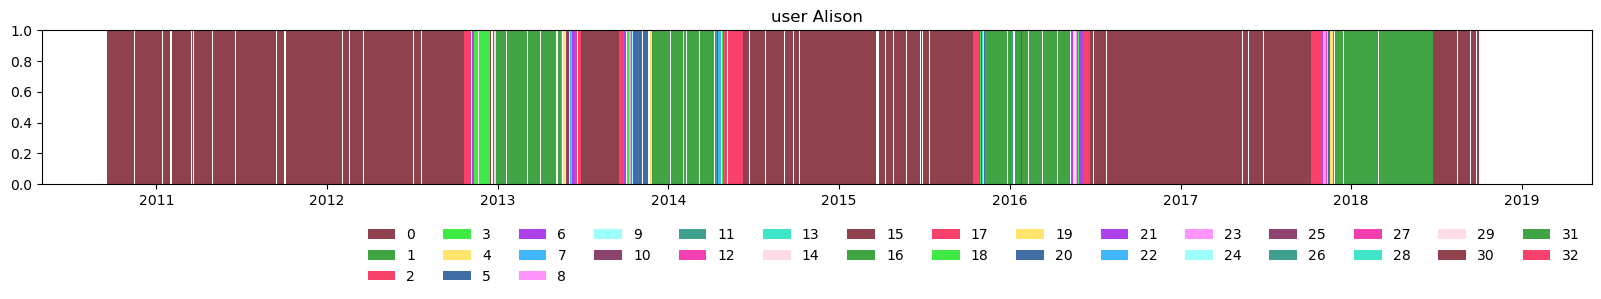

In [9]:
user = "Alison"
start_datetime = pd.to_datetime('2010-05-01 030000').tz_localize(tz='US/Pacific')
end_datetime = pd.to_datetime('2019-05-31 030000').tz_localize(tz='US/Pacific')
tortoise_stay_cluster.plot_diary(user, start_datetime=start_datetime, end_datetime=end_datetime,legend=True)

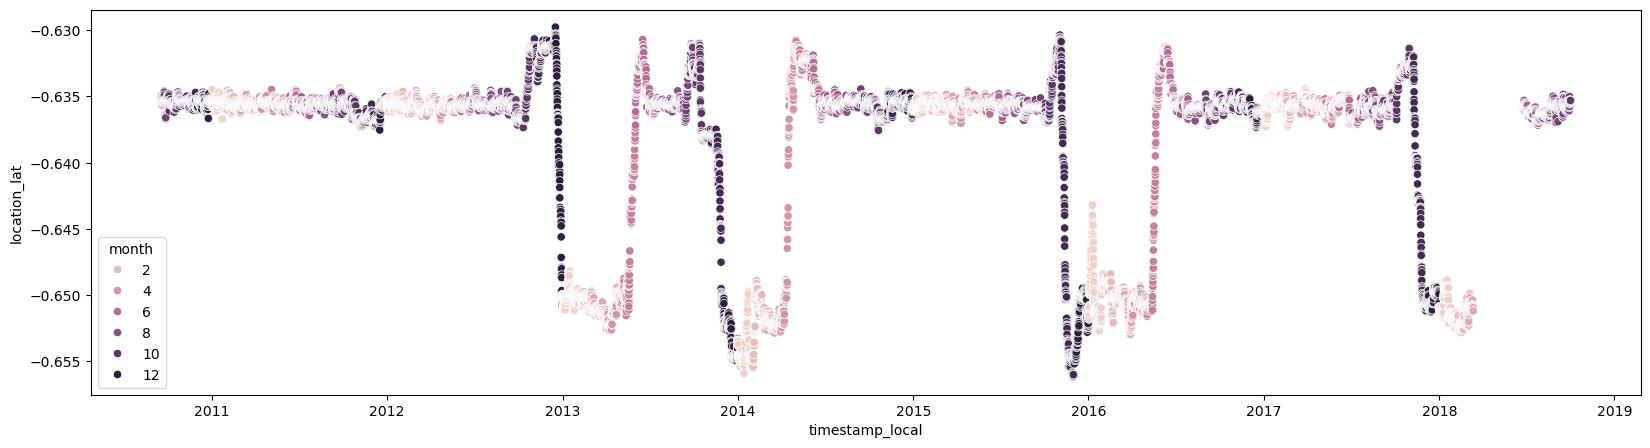

In [10]:
plt.figure(figsize = (20,5))
sns.scatterplot(alison, x = "timestamp_local", y="location_lat", hue = "month")
plt.show()

Based on the figures above, I observe 7 migration events. 

In [11]:
from skmob.measures.individual import radius_of_gyration
alison_rog = []
date_list = []
for date in alison.date.unique():
    date_list.append(date)
    rog = radius_of_gyration(alison_trajectory[alison_trajectory["date"] == date],show_progress=False)["radius_of_gyration"][0]*1000
    alison_rog.append(rog)

In [12]:
date_list = pd.to_datetime(date_list)

In [13]:
alison_rofg = pd.DataFrame(data = {"date": date_list, "rog":alison_rog})

<Axes: xlabel='date', ylabel='rog'>

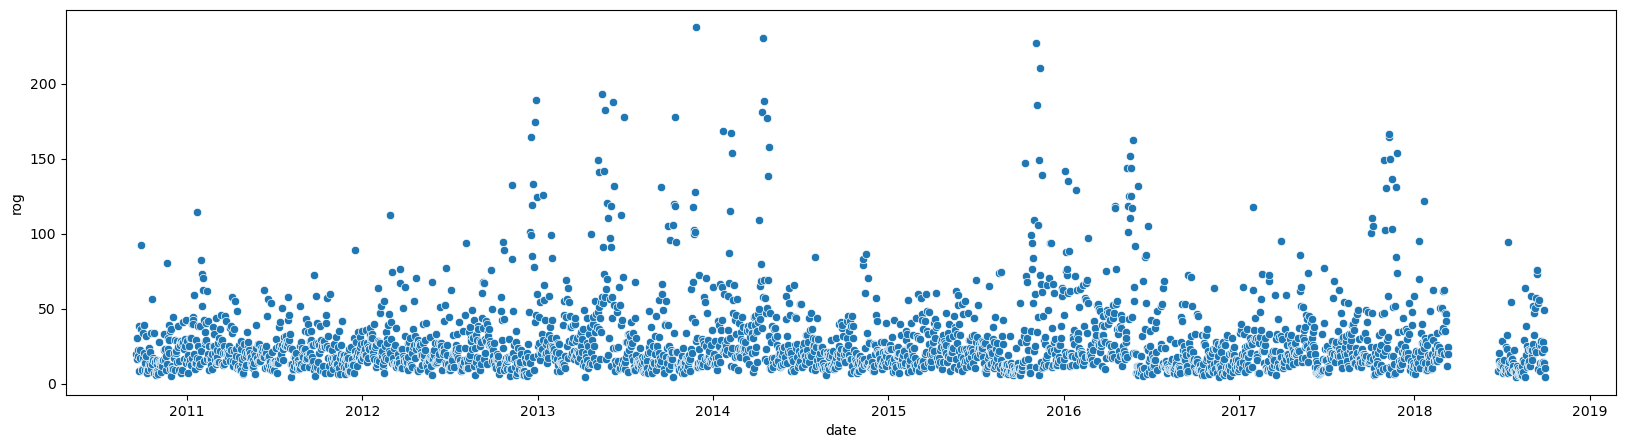

In [14]:
plt.figure(figsize = (20,5))
sns.scatterplot(data = alison_rofg, x="date", y="rog") 
#again I observe 7 migration events! 

In [15]:
#zooming in on 7 different events

In [16]:
alison_1 = alison_rofg[(alison_rofg['date'] >= '2012-11-01') & (alison_rofg['date'] <= '2013-01-01')]
alison_1 = alison_1.sort_values(by='rog', ascending=False)
alison_1.head(10)
#migration 1: 2012-12-16 to 2012-12-29

,date,rog
833,2012-12-28,188.935454
830,2012-12-25,174.302389
823,2012-12-18,164.243265
827,2012-12-22,133.274340
782,2012-11-07,132.525568
834,2012-12-29,124.392131
824,2012-12-19,119.353076
821,2012-12-16,101.152590
822,2012-12-17,99.173905
825,2012-12-20,85.192175


In [17]:
alison_2 = alison_rofg[(alison_rofg['date'] >= '2013-05-01') & (alison_rofg['date'] <= '2013-06-30')]
alison_2 = alison_2.sort_values(by='rog', ascending=False)
alison_2.head(10)
#migration 2: 2013-05-14 to 2013-06-08

,date,rog
970,2013-05-14,193.123505
993,2013-06-06,187.720652
976,2013-05-20,182.344667
1017,2013-06-30,177.394611
961,2013-05-05,148.988877
974,2013-05-18,141.521444
963,2013-05-07,141.179274
995,2013-06-08,131.969195
981,2013-05-25,120.679183
988,2013-06-01,118.463687


In [18]:
alison_3 = alison_rofg[(alison_rofg['date'] >= '2013-11-01') & (alison_rofg['date'] <= '2013-12-31')]
alison_3 = alison_3.sort_values(by='rog', ascending=False)
alison_3.head(10)
#migration 3: 2013-11-16 to 2013-12-02

,date,rog
1166,2013-11-26,237.529890
1164,2013-11-24,127.667016
1159,2013-11-19,117.777138
1161,2013-11-21,102.280852
1163,2013-11-23,101.257404
1162,2013-11-22,99.506493
1172,2013-12-02,72.526883
1187,2013-12-17,70.293186
1160,2013-11-20,67.903453
1156,2013-11-16,63.197504


In [19]:
alison_4 = alison_rofg[(alison_rofg['date'] >= '2014-02-01') & (alison_rofg['date'] <= '2014-03-30')]
alison_4 = alison_4.sort_values(by='rog', ascending=False)
alison_4.head(10)
#migration 4: 2014-02-03 to 2014-02-19

,date,rog
1239,2014-02-07,167.263055
1242,2014-02-10,153.816831
1237,2014-02-05,115.269978
1234,2014-02-02,86.766607
1235,2014-02-03,66.776791
1245,2014-02-13,65.563928
1251,2014-02-19,56.358016
1244,2014-02-12,55.856151
1243,2014-02-11,46.823826
1249,2014-02-17,45.966702


In [20]:
alison_5 = alison_rofg[(alison_rofg['date'] >= '2015-11-01') & (alison_rofg['date'] <= '2015-12-31')]
alison_5 = alison_5.sort_values(by='rog', ascending=False)
alison_5.head(10)
#migration 5: 2015-11-01 to 2015-12-06

,date,rog
1875,2015-11-05,226.783726
1882,2015-11-12,210.225865
1876,2015-11-06,185.612602
1881,2015-11-11,148.746124
1886,2015-11-16,139.178183
1871,2015-11-01,108.869882
1878,2015-11-08,105.869733
1906,2015-12-06,93.956199
1904,2015-12-04,93.678547
1883,2015-11-13,72.050151


In [21]:
alison_6 = alison_rofg[(alison_rofg['date'] >= '2016-04-01') & (alison_rofg['date'] <= '2016-05-31')]
alison_6 = alison_6.sort_values(by='rog', ascending=False)
alison_6.head(10)
#migration 6: 2016-04-27 to 2016-05-24

,date,rog
2076,2016-05-24,162.505423
2071,2016-05-19,151.738557
2072,2016-05-20,143.879550
2065,2016-05-13,143.722986
2068,2016-05-16,125.025431
2073,2016-05-21,124.762684
2067,2016-05-15,118.687408
2039,2016-04-17,118.404812
2075,2016-05-23,116.943202
2040,2016-04-18,116.818223


In [22]:
alison_7 = alison_rofg[(alison_rofg['date'] >= '2017-11-01') & (alison_rofg['date'] <= '2017-12-31')]
alison_7 = alison_7.sort_values(by='rog', ascending=False)
alison_7.head(10)
#migration 7: 2017-11-01 to 2017-11-26

,date,rog
2604,2017-11-09,166.494704
2603,2017-11-08,164.273982
2621,2017-11-26,153.935776
2606,2017-11-11,150.013901
2611,2017-11-16,136.122755
2618,2017-11-23,131.019243
2597,2017-11-02,130.147009
2610,2017-11-15,102.884547
2596,2017-11-01,102.456864
2619,2017-11-24,84.673080


Christian

In [23]:
christian = tortoise.query("individual_local_identifier == 'Christian'")
christian_trajectory = tortoise_trajectory.query("uid == 'Christian'")
christian_stay_location = tortoise_stay_location.query("uid == 'Christian'")
christian_stay_location.shape[0]/christian_trajectory.shape[0]
christian_stay_cluster = tortoise_stay_cluster.query("uid == 'Christian'")
christian_stay_cluster.shape[0]/christian_trajectory.shape[0]

0.04822508174739467

<Axes: title={'center': 'user Christian'}>

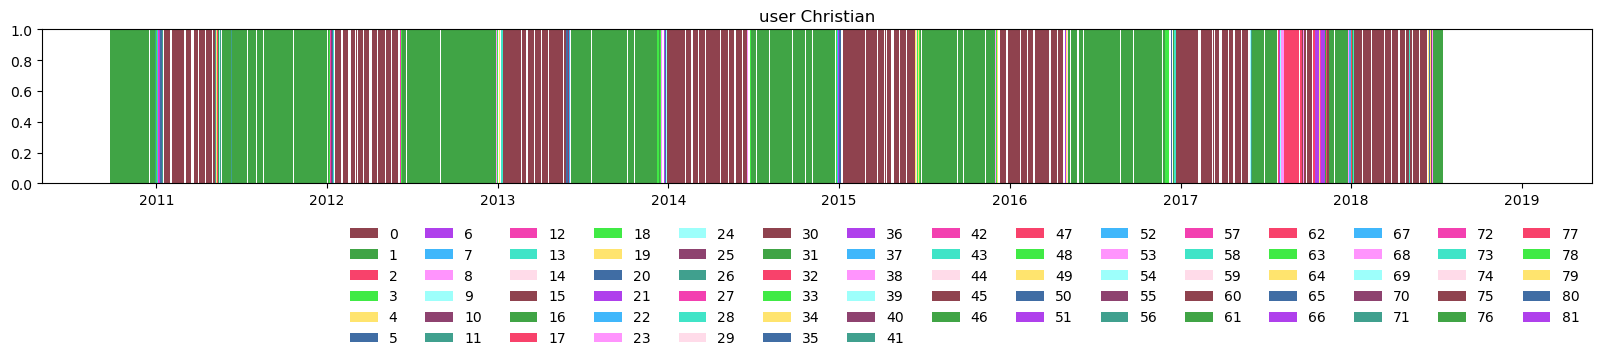

In [24]:
user = "Christian"
start_datetime = pd.to_datetime('2010-05-01 030000').tz_localize(tz='US/Pacific')
end_datetime = pd.to_datetime('2019-05-31 030000').tz_localize(tz='US/Pacific')
tortoise_stay_cluster.plot_diary(user, start_datetime=start_datetime, end_datetime=end_datetime,legend=True)

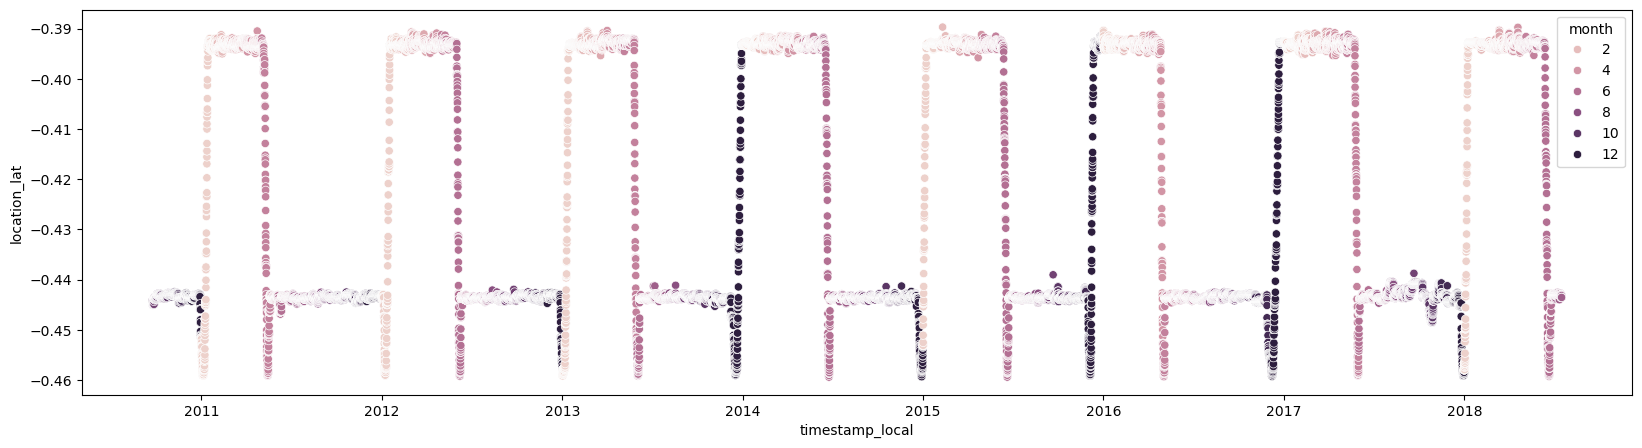

In [25]:
plt.figure(figsize = (20,5))
sns.scatterplot(christian, x = "timestamp_local", y="location_lat", hue = "month")
plt.show()

In [26]:
christian_rog = []
date_list = []
for date in christian.date.unique():
    date_list.append(date)
    rog = radius_of_gyration(christian_trajectory[christian_trajectory["date"] == date],show_progress=False)["radius_of_gyration"][0]*1000
    christian_rog.append(rog)

In [27]:
date_list = pd.to_datetime(date_list)

In [28]:
christian_rofg = pd.DataFrame(data = {"date": date_list, "rog":christian_rog})

<Axes: xlabel='date', ylabel='rog'>

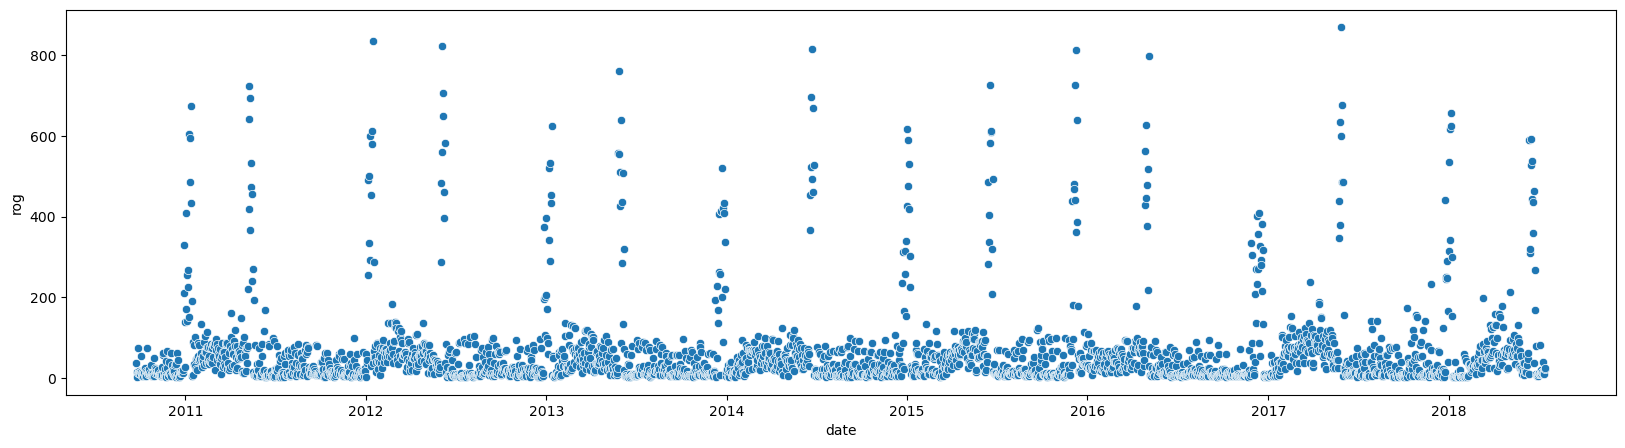

In [29]:
plt.figure(figsize = (20,5))
sns.scatterplot(data = christian_rofg, x="date", y="rog") 

In [90]:
christian

,event_id,timestamp,timestamp_UTC,timestamp_local,minute_diff,location_long,location_lat,eobs_temperature,ground_speed,heading,height_above_ellipsoid,individual_taxon_canonical_name,individual_local_identifier,year,month,date
198202,33691506,2010-09-24 13:01:20.000,2010-09-24 13:01:20+00:00,2010-09-24 06:01:20-07:00,0,-91.092650,-0.444119,5,0.07,11.14,1115.1,Chelonoidis,Christian,2010,9,2010-09-24
198203,33691507,2010-09-24 14:00:21.998,2010-09-24 14:00:21.998000+00:00,2010-09-24 07:00:21.998000-07:00,59,-91.092997,-0.444586,12,0.07,3.93,1133.9,Chelonoidis,Christian,2010,9,2010-09-24
198204,77563565,2010-09-24 15:00:49.998,2010-09-24 15:00:49.998000+00:00,2010-09-24 08:00:49.998000-07:00,60,-91.093024,-0.444951,21,0.07,19.01,1105.9,Chelonoidis,Christian,2010,9,2010-09-24
198205,77563566,2010-09-24 16:00:31.001,2010-09-24 16:00:31.001000+00:00,2010-09-24 09:00:31.001000-07:00,59,-91.092979,-0.445068,19,0.87,320.47,1060.0,Chelonoidis,Christian,2010,9,2010-09-24
198206,77563567,2010-09-24 17:00:55.998,2010-09-24 17:00:55.998000+00:00,2010-09-24 10:00:55.998000-07:00,60,-91.092383,-0.444913,17,0.12,342.10,1085.1,Chelonoidis,Christian,2010,9,2010-09-24
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
240706,6749693853,2018-07-16 19:00:21.998,2018-07-16 19:00:21.998000+00:00,2018-07-16 12:00:21.998000-07:00,59,-91.091061,-0.443610,10,0.17,353.89,1078.0,Chelonoidis,Christian,2018,7,2018-07-16
240707,6749693854,2018-07-16 20:00:33.000,2018-07-16 20:00:33+00:00,2018-07-16 13:00:33-07:00,60,-91.091029,-0.443608,12,0.24,19.66,1098.6,Chelonoidis,Christian,2018,7,2018-07-16
240708,6749693855,2018-07-16 21:00:31.000,2018-07-16 21:00:31+00:00,2018-07-16 14:00:31-07:00,59,-91.091023,-0.443567,12,0.22,9.83,1077.9,Chelonoidis,Christian,2018,7,2018-07-16
240709,6749693856,2018-07-16 22:00:50.000,2018-07-16 22:00:50+00:00,2018-07-16 15:00:50-07:00,60,-91.090981,-0.443550,11,0.18,342.75,1075.0,Chelonoidis,Christian,2018,7,2018-07-16


In [91]:
def detect_migratory_events(df, distance_col='rog', threshold=0.75, max_gap_days=30):
    # Calculate the threshold for significant movement
    movement_threshold = df[distance_col].quantile(threshold)
    print(f"Movement Threshold (75th Percentile): {movement_threshold}")

    # Identify days with significant movement
    df['is_significant_movement'] = df[distance_col] > movement_threshold

    # Get the dates where significant movement occurred
    significant_dates = df[df['is_significant_movement']]['date'].reset_index(drop=True)

    migratory_events = []
    current_start = None
    current_end = None

    for i in range(len(significant_dates)):
        if current_start is None:
            current_start = significant_dates[i]
            current_end = significant_dates[i]
        else:
            # Check for gaps
            days_diff = (significant_dates[i] - current_end).days
            if days_diff <= max_gap_days:
                current_end = significant_dates[i]
            else:
                # Store the current event and reset
                migratory_events.append((current_start, current_end))
                current_start = significant_dates[i]
                current_end = significant_dates[i]

    # Append the last event if it exists
    if current_start is not None and current_end is not None:
        migratory_events.append((current_start, current_end))

    return migratory_events

In [92]:
christian_migratory_events = detect_migratory_events(christian_rofg)
christian_migratory_events

Movement Threshold (75th Percentile): 66.87413794439763


[(Timestamp('2010-09-27 00:00:00'), Timestamp('2010-10-15 00:00:00')),
 (Timestamp('2010-11-26 00:00:00'), Timestamp('2010-11-26 00:00:00')),
 (Timestamp('2010-12-29 00:00:00'), Timestamp('2011-09-24 00:00:00')),
 (Timestamp('2011-12-09 00:00:00'), Timestamp('2013-08-23 00:00:00')),
 (Timestamp('2013-10-05 00:00:00'), Timestamp('2013-12-29 00:00:00')),
 (Timestamp('2014-01-31 00:00:00'), Timestamp('2015-03-03 00:00:00')),
 (Timestamp('2015-04-05 00:00:00'), Timestamp('2016-09-22 00:00:00')),
 (Timestamp('2016-11-04 00:00:00'), Timestamp('2016-12-22 00:00:00')),
 (Timestamp('2017-01-28 00:00:00'), Timestamp('2018-01-08 00:00:00')),
 (Timestamp('2018-03-05 00:00:00'), Timestamp('2018-07-04 00:00:00'))]

In [96]:
#Dr. Li. I worked for a very long time on this function above.
#I wanted to be able to write a function that detected a migratory event. 
#This was out of the scope of my knowledge, so I employed ChatGPT to help in writing the function.
#I went through several different versions of the function. 
#The one above is not the best attempt, but it is the last one that I am willing to try bc this has been incredibly frustrating.
#I was trying to create a function that would detect when MOST of the days within a 30 day period had an above average radius of gyration.
#After the function detects the days within a 30 day period that have high ROG, it groups them together
#And then it finds the earliest and latest dates within the group and prints them out.
#I think the function keeps getting caught on finding the groups within a 30 day period. 
#I would've run this function for each turtle! 
#If you have any suggestions for how to make this function, or a different direction, that would be awesome! 
#From here on out, I am just going to make a rough estimate for the dates of migration for each turtle

In [ ]:
#Here is another attempt at the function, with some debugging lines as well!

def find_migratory_events(df, num_events):
    # Ensure date is in datetime format
    df['date'] = pd.to_datetime(df['date'])
    
    # Calculate the 75th percentile of rog
    percentile_75 = df['rog'].quantile(0.75)
    print(f"75th Percentile ROG: {percentile_75}")

    # Create a column indicating whether the rog is above the 75th percentile
    df['above_75th_percentile'] = df['rog'] > percentile_75
    print(f"Above 75th Percentile Column:\n{df[['date', 'rog', 'above_75th_percentile']].head(10)}")

    # Initialize an empty list to hold the migratory events
    migratory_events = []
    
    # Iterate through the DataFrame and find dates above the 75th percentile
    above_avg_dates = df[df['above_75th_percentile']].reset_index(drop=True)

    if not above_avg_dates.empty:
        # Start tracking the current event
        current_start = above_avg_dates.loc[0, 'date']
        current_end = above_avg_dates.loc[0, 'date']
        
        for i in range(1, len(above_avg_dates)):
            # Check if the date is within 30 days of the current_end
            date_diff = (above_avg_dates.loc[i, 'date'] - current_end).days
            
            if date_diff <= 30:
                current_end = above_avg_dates.loc[i, 'date']
            else:
                # Append the current event to the list
                migratory_events.append((current_start, current_end))
                current_start = above_avg_dates.loc[i, 'date']
                current_end = above_avg_dates.loc[i, 'date']
        
        # Append the last event if it hasn't been added
        migratory_events.append((current_start, current_end))

    # Limit to the number of migratory events requested
    migratory_events = migratory_events[:num_events]
    
    print(f"Migratory Events:\n{migratory_events}")
    
    return migratory_events


In [ ]:
#Christian migrations:
#3: 01/01/2012-02/01/2012
#4: 05/01/2012-06/01/2012
#5: 01/01/2013-02/02/2013
#6: 05/01/2013-06/01/2013
#7: 12/01/2013-01/01/2014
#8: 05/01/2014-06/01/2014
#9: 12/15/2014-01/15/2015
#10: 05/01/2015-06/01/2015
#11: 11/25/2015-12/25/2015
#12: 04/01/2016-05/01/2016
#13: 12/01/2016-01/01/2017
#14: 05/01/2017-06/01/2017
#15: 01/01/2018-02/01/2018
#16: 05/01/2018-06/01/2018

Marilyn!

In [32]:
marilyn = tortoise.query("individual_local_identifier == 'Marilyn'")
marilyn_trajectory = tortoise_trajectory.query("uid == 'Marilyn'")
marilyn_stay_location = tortoise_stay_location.query("uid == 'Marilyn'")
marilyn_stay_location.shape[0]/marilyn_trajectory.shape[0]
marilyn_stay_cluster = tortoise_stay_cluster.query("uid == 'Marilyn'")
marilyn_stay_cluster.shape[0]/marilyn_trajectory.shape[0]

0.0523297308319739

<Axes: title={'center': 'user Marilyn'}>

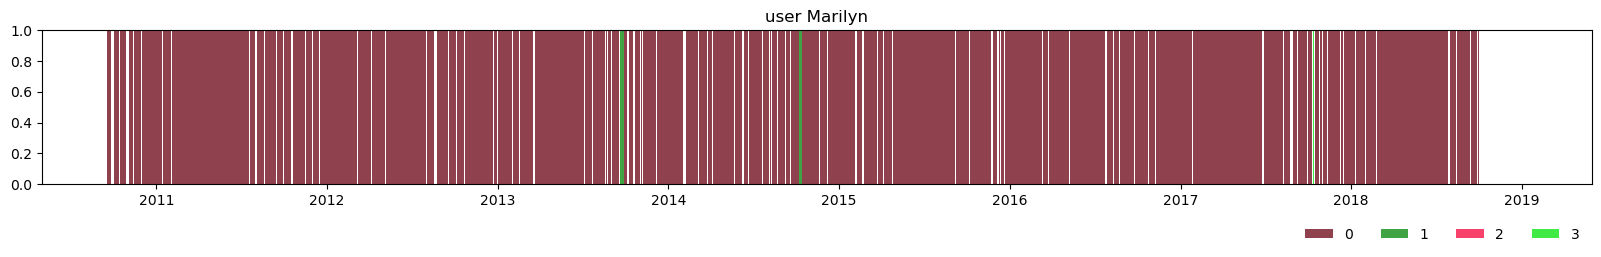

In [33]:
user = "Marilyn"
start_datetime = pd.to_datetime('2010-05-01 030000').tz_localize(tz='US/Pacific')
end_datetime = pd.to_datetime('2019-05-31 030000').tz_localize(tz='US/Pacific')
tortoise_stay_cluster.plot_diary(user, start_datetime=start_datetime, end_datetime=end_datetime,legend=True)

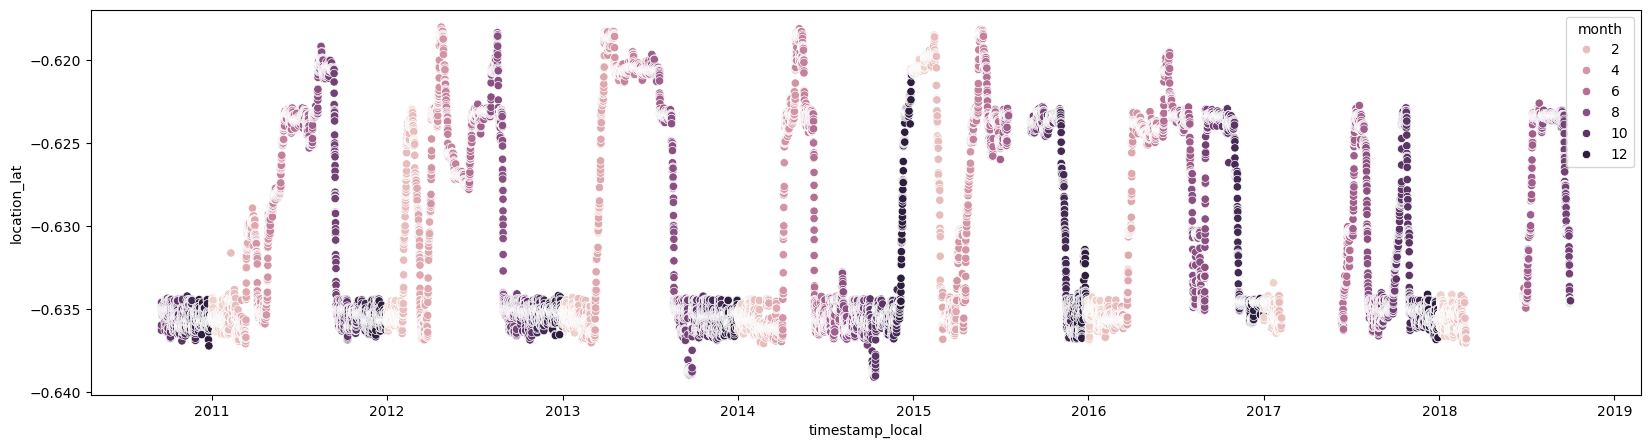

In [34]:
plt.figure(figsize = (20,5))
sns.scatterplot(marilyn, x = "timestamp_local", y="location_lat", hue = "month")
plt.show()

In [35]:
marilyn_rog = []
date_list = []
for date in marilyn.date.unique():
    date_list.append(date)
    rog = radius_of_gyration(marilyn_trajectory[marilyn_trajectory["date"] == date],show_progress=False)["radius_of_gyration"][0]*1000
    marilyn_rog.append(rog)

In [36]:
date_list = pd.to_datetime(date_list)

In [37]:
marilyn_rofg = pd.DataFrame(data = {"date": date_list, "rog": marilyn_rog})

<Axes: xlabel='date', ylabel='rog'>

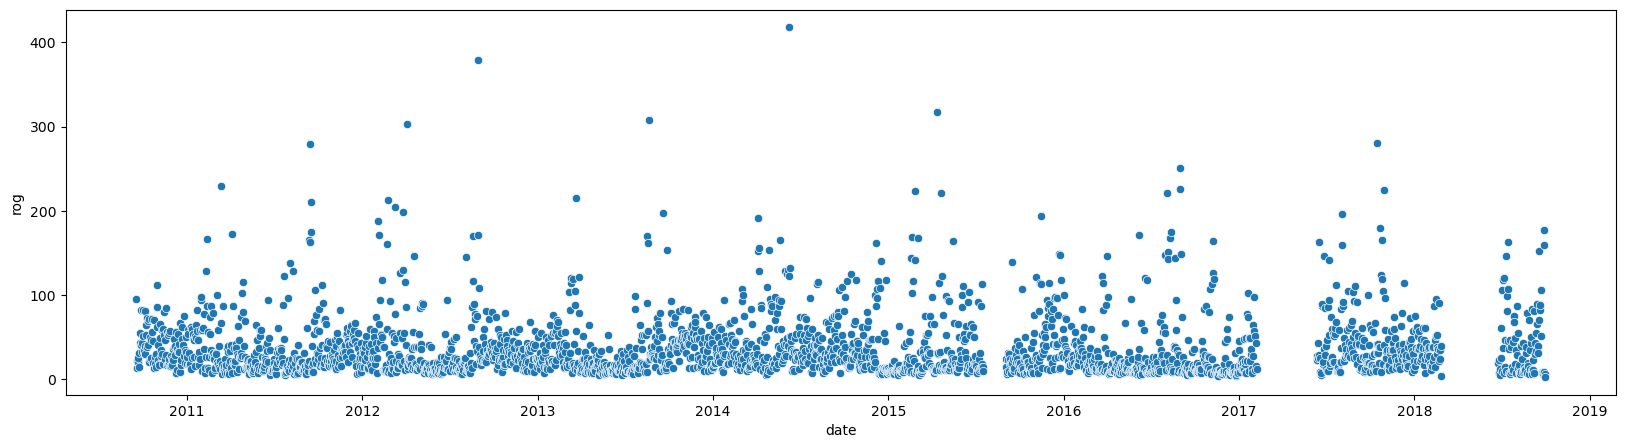

In [38]:
plt.figure(figsize = (20,5))
sns.scatterplot(data = marilyn_rofg, x="date", y="rog")

In [ ]:
#I observe 9 migrations:
#1: 04/01/2011-10/31/2011
#2: 03/01/2012-09/20/2012
#3: 04/01/2013-9/30/2013
#4: 05/01/2014-07/01/2014
#5: 12/01/2014-05/01/2015
#6: 11/01/2015-12/01/2015
#7: 04/01/2016-11/01/2016
#8: 06/01/2017-10/01/2017
#9: 07/01/2018-09/01/2018

Kitty

In [39]:
kitty = tortoise.query("individual_local_identifier == 'Kitty'")
kitty_trajectory = tortoise_trajectory.query("uid == 'Kitty'")
kitty_stay_location = tortoise_stay_location.query("uid == 'Kitty'")
kitty_stay_location.shape[0]/kitty_trajectory.shape[0]
kitty_stay_cluster = tortoise_stay_cluster.query("uid == 'Kitty'")
kitty_stay_cluster.shape[0]/kitty_trajectory.shape[0]

0.03981979727193092

<Axes: title={'center': 'user Kitty'}>

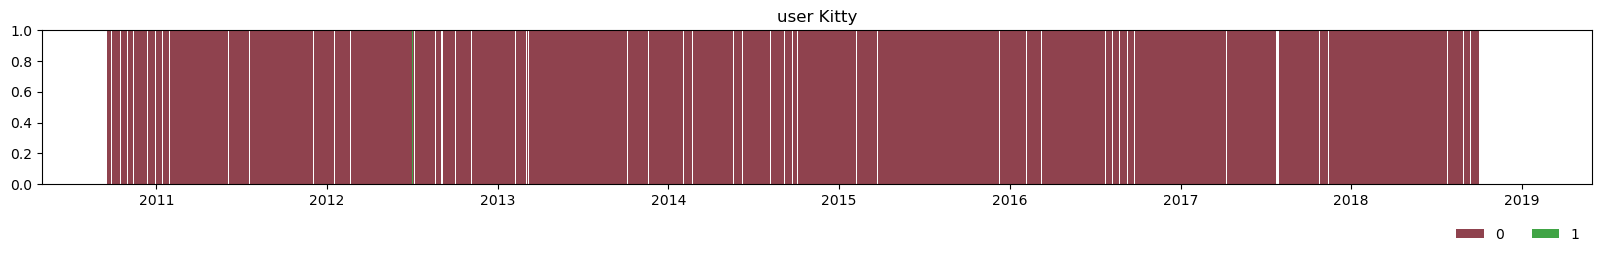

In [40]:
user = "Kitty"
start_datetime = pd.to_datetime('2010-05-01 030000').tz_localize(tz='US/Pacific')
end_datetime = pd.to_datetime('2019-05-31 030000').tz_localize(tz='US/Pacific')
tortoise_stay_cluster.plot_diary(user, start_datetime=start_datetime, end_datetime=end_datetime,legend=True)

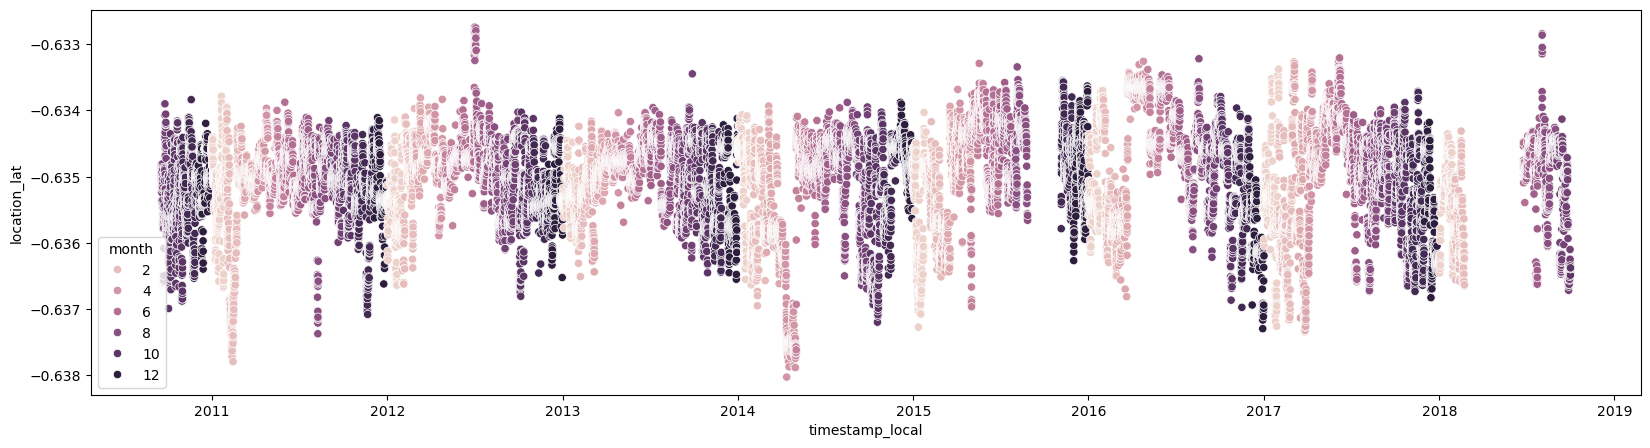

In [41]:
plt.figure(figsize = (20,5))
sns.scatterplot(kitty, x = "timestamp_local", y="location_lat", hue = "month")
plt.show()

In [42]:
kitty_rog = []
date_list = []
for date in kitty.date.unique():
    date_list.append(date)
    rog = radius_of_gyration(kitty_trajectory[kitty_trajectory["date"] == date],show_progress=False)["radius_of_gyration"][0]*1000
    kitty_rog.append(rog)

In [43]:
date_list = pd.to_datetime(date_list)

In [44]:
kitty_rofg = pd.DataFrame(data = {"date": date_list, "rog": kitty_rog})

<Axes: xlabel='date', ylabel='rog'>

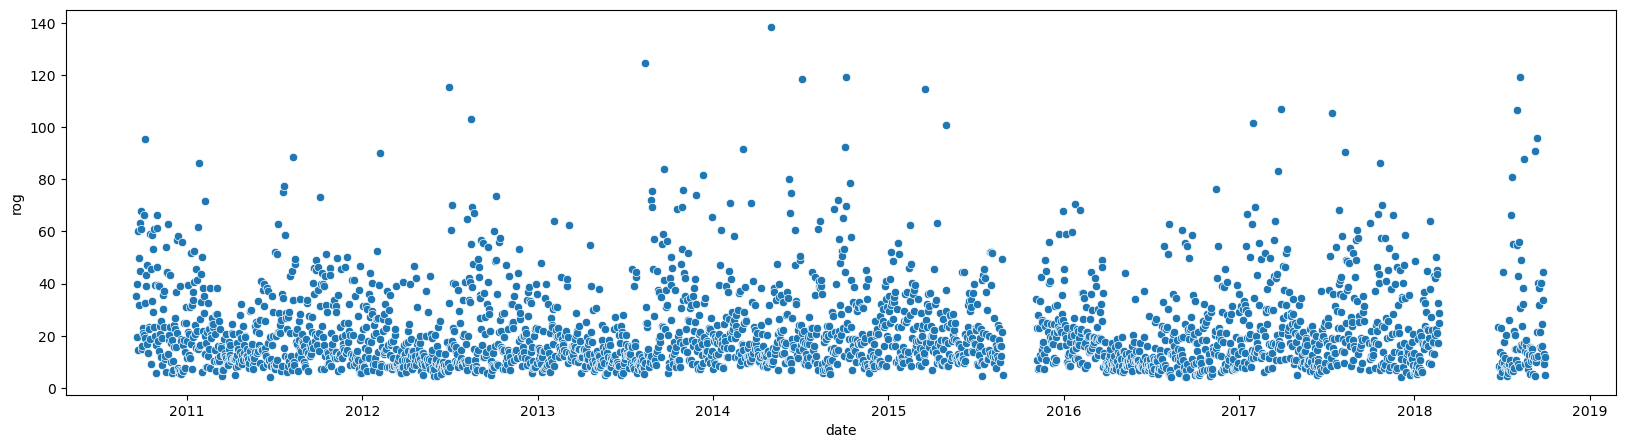

In [45]:
plt.figure(figsize = (20,5))
sns.scatterplot(data = kitty_rofg, x="date", y="rog")

In [ ]:
#I observe 4 migrations:
#1: 02/01/2011-05/01/2011 
#2. 03/01/2014-04/15/2014
#3. 01/01/2017-04/01/2017
#4. 07/01/2018-08/01/2018

Connor

In [46]:
connor = tortoise.query("individual_local_identifier == 'Connor'")
connor_trajectory = tortoise_trajectory.query("uid == 'Connor'")
connor_stay_location = tortoise_stay_location.query("uid == 'Connor'")
connor_stay_location.shape[0]/connor_trajectory.shape[0]
connor_stay_cluster = tortoise_stay_cluster.query("uid == 'Connor'")
connor_stay_cluster.shape[0]/connor_trajectory.shape[0]

0.05639232855229196

<Axes: title={'center': 'user Connor'}>

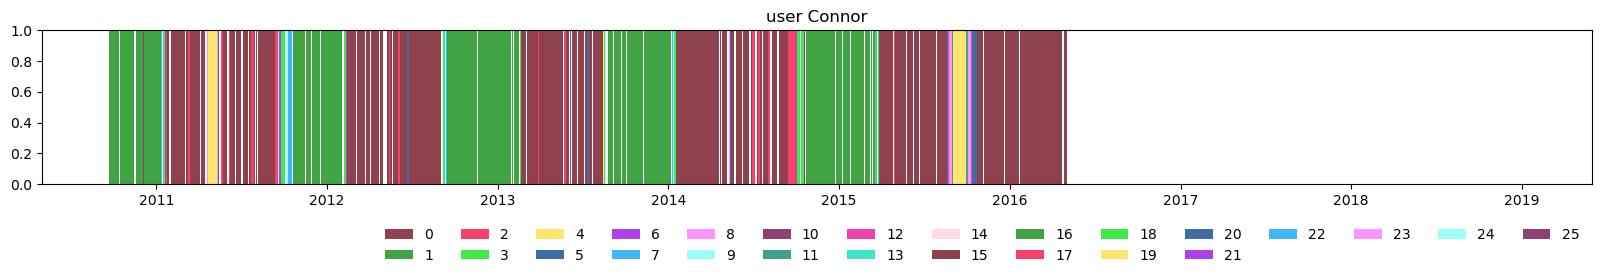

In [47]:
user = "Connor"
start_datetime = pd.to_datetime('2010-05-01 030000').tz_localize(tz='US/Pacific')
end_datetime = pd.to_datetime('2019-05-31 030000').tz_localize(tz='US/Pacific')
tortoise_stay_cluster.plot_diary(user, start_datetime=start_datetime, end_datetime=end_datetime,legend=True)

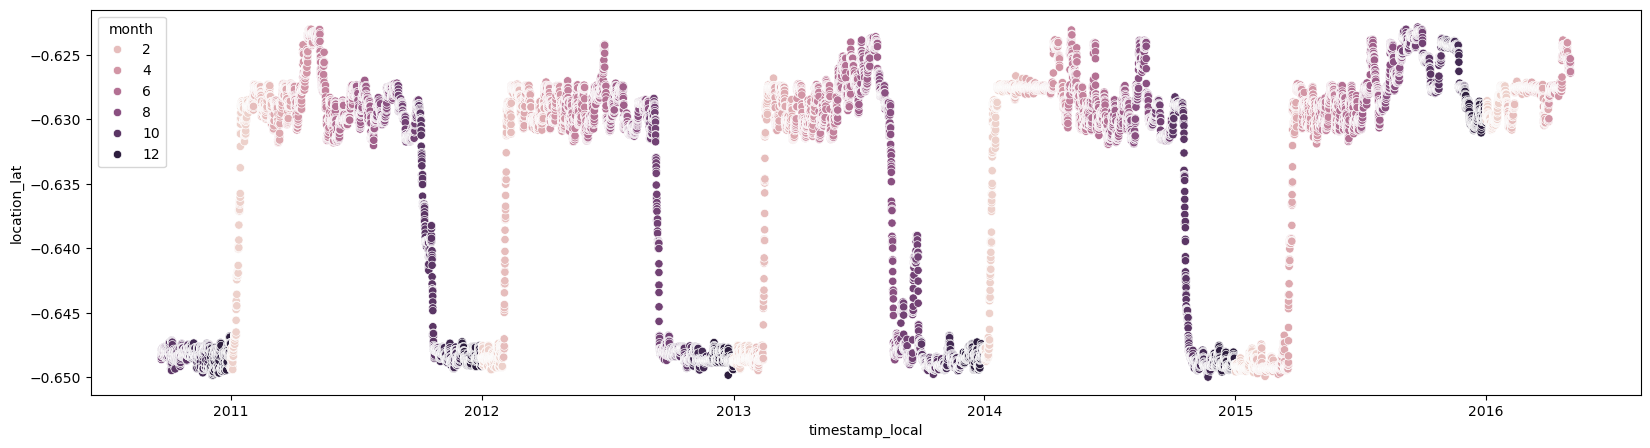

In [48]:
plt.figure(figsize = (20,5))
sns.scatterplot(connor, x = "timestamp_local", y="location_lat", hue = "month")
plt.show()

In [49]:
connor_rog = []
date_list = []
for date in connor.date.unique():
    date_list.append(date)
    rog = radius_of_gyration(connor_trajectory[connor_trajectory["date"] == date],show_progress=False)["radius_of_gyration"][0]*1000
    connor_rog.append(rog)

In [50]:
date_list = pd.to_datetime(date_list)

In [51]:
connor_rofg = pd.DataFrame(data = {"date": date_list, "rog": connor_rog})

<Axes: xlabel='date', ylabel='rog'>

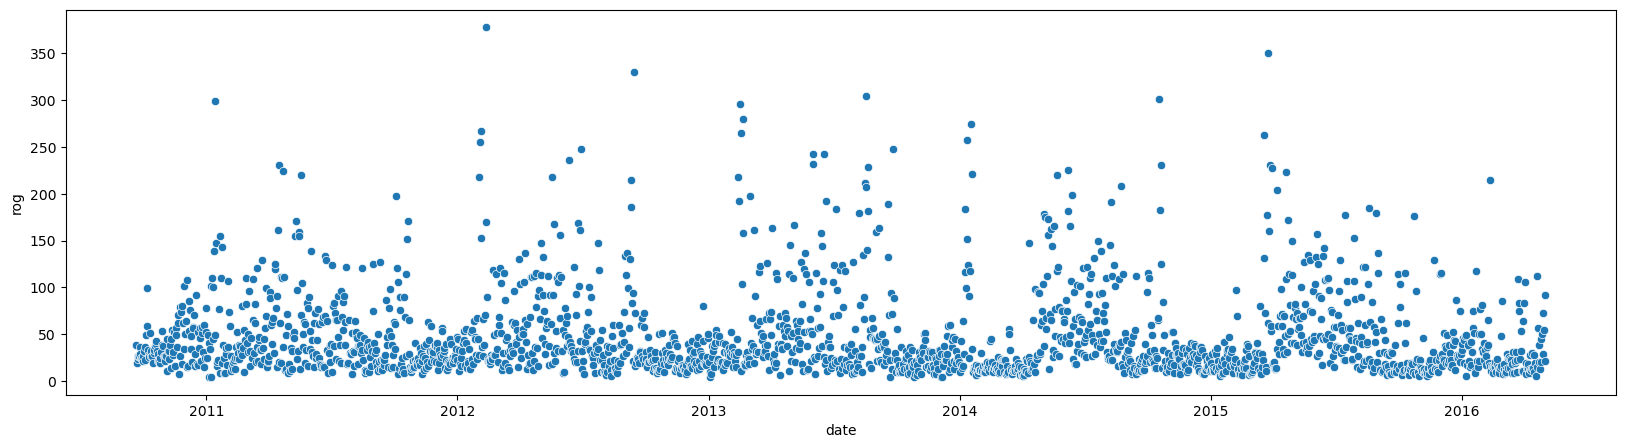

In [52]:
plt.figure(figsize = (20,5))
sns.scatterplot(data = connor_rofg, x="date", y="rog")

In [ ]:
#I observe 9 migrations:
#1. 01/01/2011-02/01/2011
#2. 11/01/2011-12/01/2011
#3. 02/01/2012-03/01/2012
#4. 09/01/2012-10/01/2012
#5. 02/01/2013-03/01/2013
#6. 08/01/2013-09/01/2013
#7. 01/01/2014-02/01/2014
#8. 11/01/2014-12/01/2014
#9. 02/01/2015-03/01/2013

Helver

In [53]:
helber = tortoise.query("individual_local_identifier == 'Helber'")
helber_trajectory = tortoise_trajectory.query("uid == 'Helber'")
helber_stay_location = tortoise_stay_location.query("uid == 'Helber'")
helber_stay_location.shape[0]/helber_trajectory.shape[0]
helber_stay_cluster = tortoise_stay_cluster.query("uid == 'Helber'")
helber_stay_cluster.shape[0]/helber_trajectory.shape[0]

0.019425041851873232

<Axes: title={'center': 'user Helber'}>

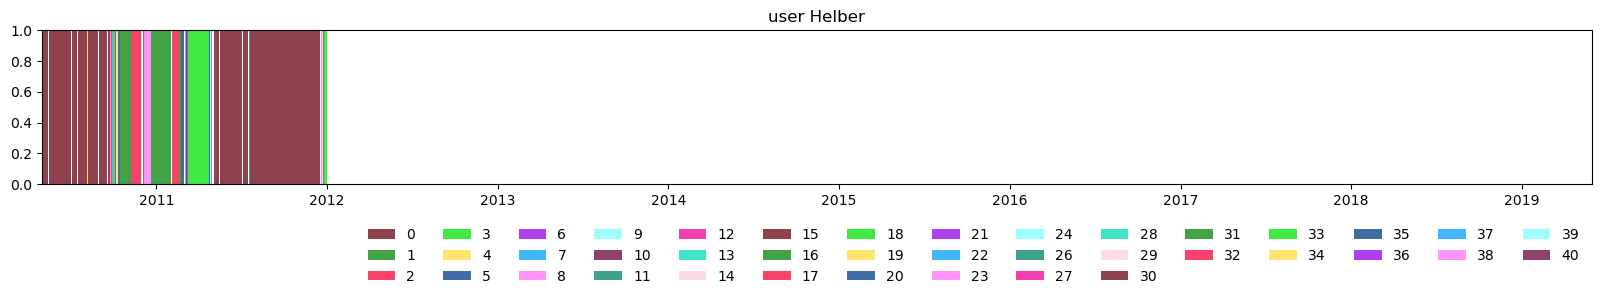

In [54]:
user = "Helber"
start_datetime = pd.to_datetime('2010-05-01 030000').tz_localize(tz='US/Pacific')
end_datetime = pd.to_datetime('2019-05-31 030000').tz_localize(tz='US/Pacific')
tortoise_stay_cluster.plot_diary(user, start_datetime=start_datetime, end_datetime=end_datetime,legend=True)

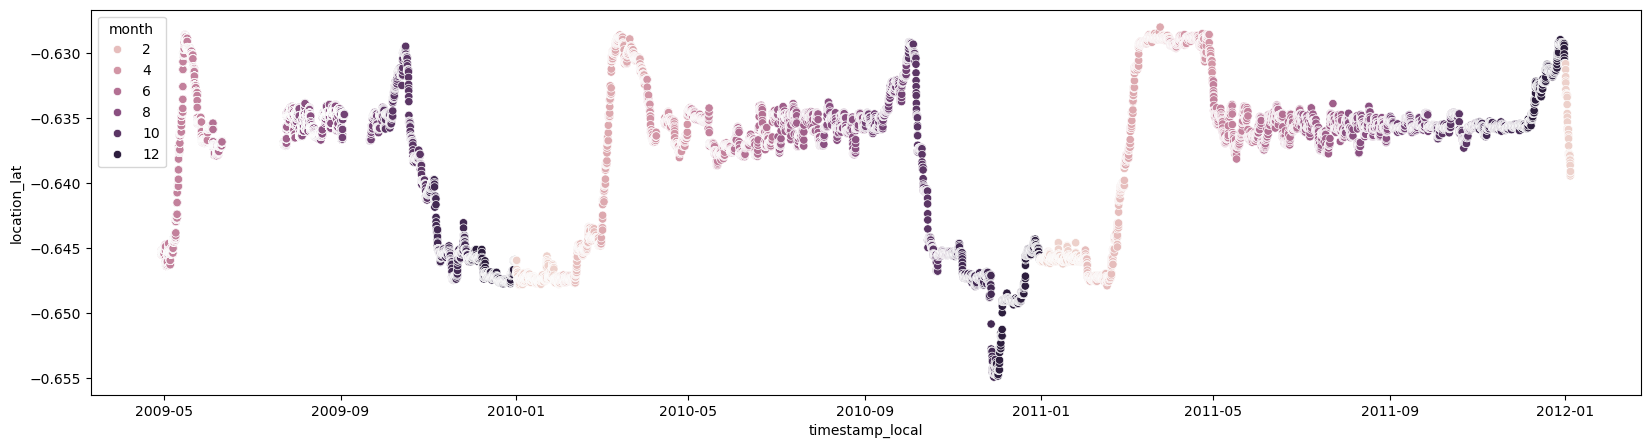

In [55]:
plt.figure(figsize = (20,5))
sns.scatterplot(helber, x = "timestamp_local", y="location_lat", hue = "month")
plt.show()

In [56]:
helber_rog = []
date_list = []
for date in helber.date.unique():
    date_list.append(date)
    rog = radius_of_gyration(helber_trajectory[helber_trajectory["date"] == date],show_progress=False)["radius_of_gyration"][0]*1000
    helber_rog.append(rog)

In [57]:
date_list = pd.to_datetime(date_list)

In [58]:
helber_rofg = pd.DataFrame(data = {"date": date_list, "rog": helber_rog})

<Axes: xlabel='date', ylabel='rog'>

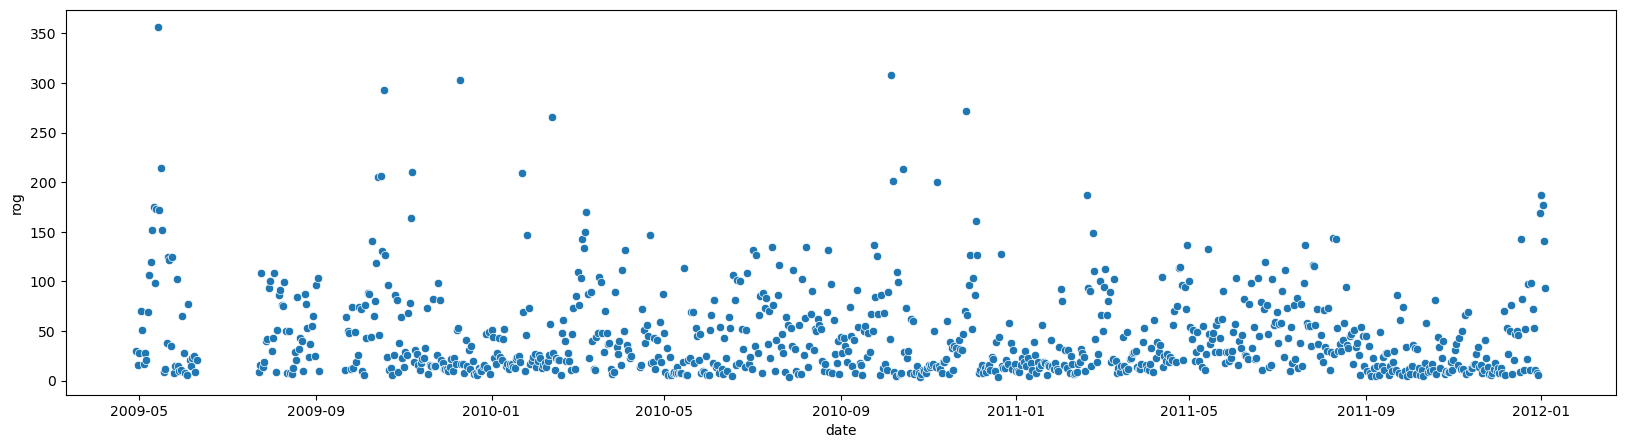

In [59]:
plt.figure(figsize = (20,5))
sns.scatterplot(data = helber_rofg, x="date", y="rog")

In [ ]:
#I observe 5 migrations:
#1: 05/01/2009-06/01/2009
#2: 10/01/2009-11/01/2009
#3. 03/15/2010-04/15/2010
#4. 10/01/2010-11/01/2010
#5. 02/01/2011-03/01/2011

Steve Devine

In [60]:
steve = tortoise.query("individual_local_identifier == 'Steve Devine'")
steve_trajectory = tortoise_trajectory.query("uid == 'Steve Devine'")
steve_stay_location = tortoise_stay_location.query("uid == 'Steve Devine'")
steve_stay_location.shape[0]/steve_trajectory.shape[0]
steve_stay_cluster = tortoise_stay_cluster.query("uid == 'Steve Devine'")
steve_stay_cluster.shape[0]/steve_trajectory.shape[0]

0.056048608951510655

<Axes: title={'center': 'user Steve Devine'}>

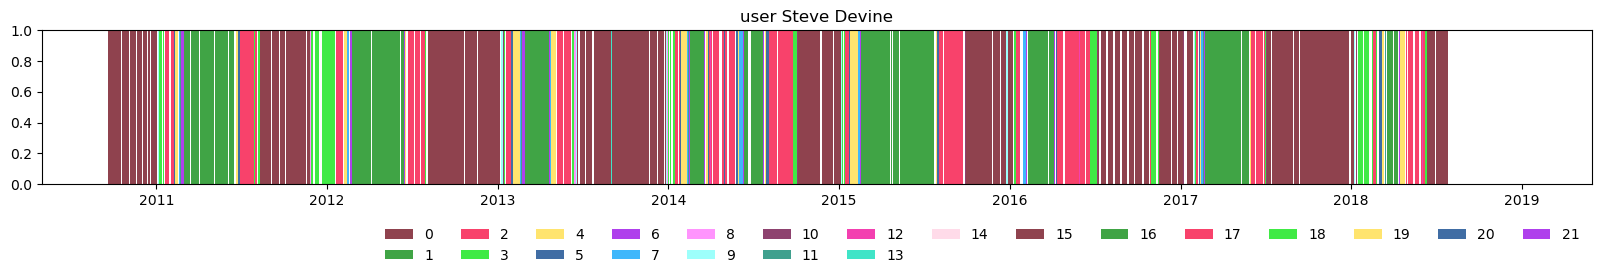

In [61]:
user = "Steve Devine"
start_datetime = pd.to_datetime('2010-05-01 030000').tz_localize(tz='US/Pacific')
end_datetime = pd.to_datetime('2019-05-31 030000').tz_localize(tz='US/Pacific')
tortoise_stay_cluster.plot_diary(user, start_datetime=start_datetime, end_datetime=end_datetime,legend=True)

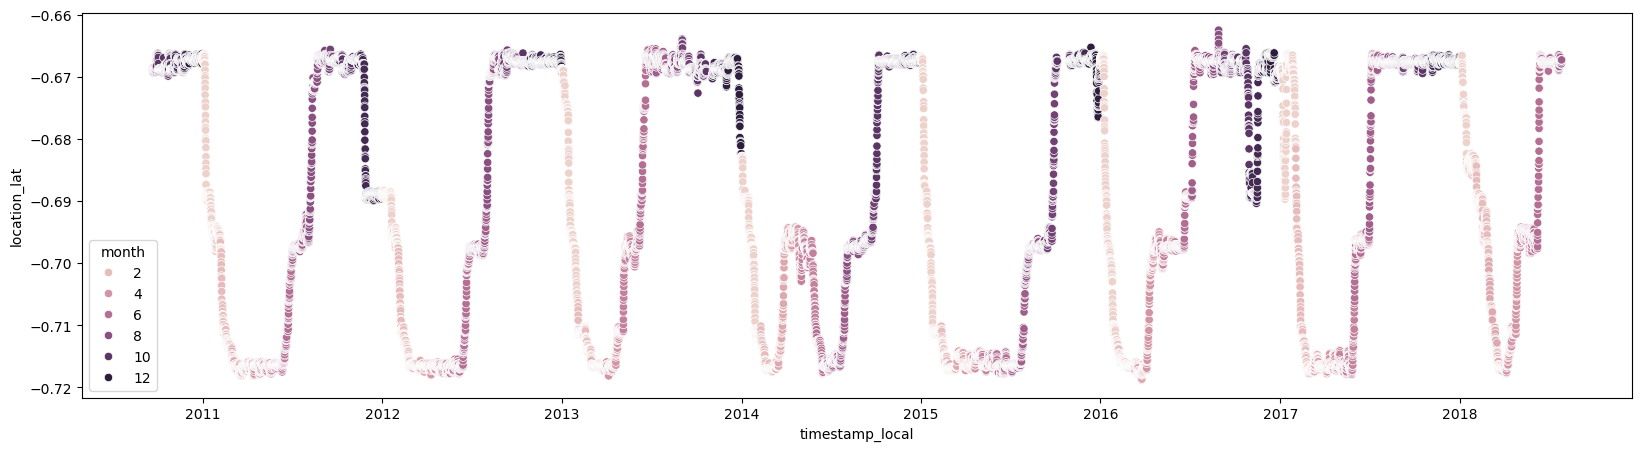

In [62]:
plt.figure(figsize = (20,5))
sns.scatterplot(steve, x = "timestamp_local", y="location_lat", hue = "month")
plt.show()

In [63]:
steve_rog = []
date_list = []
for date in steve.date.unique():
    date_list.append(date)
    rog = radius_of_gyration(steve_trajectory[steve_trajectory["date"] == date],show_progress=False)["radius_of_gyration"][0]*1000
    steve_rog.append(rog)

In [64]:
date_list = pd.to_datetime(date_list)

In [65]:
steve_rofg = pd.DataFrame(data = {"date": date_list, "rog": steve_rog})

<Axes: xlabel='date', ylabel='rog'>

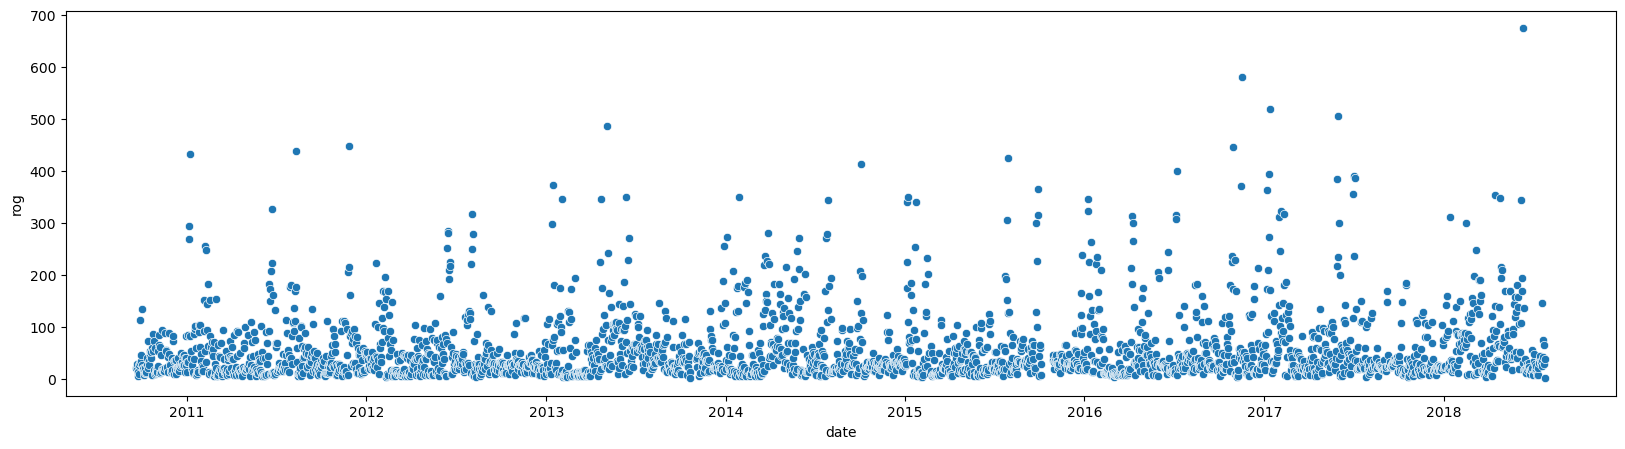

In [66]:
plt.figure(figsize = (20,5))
sns.scatterplot(data = steve_rofg, x="date", y="rog")

In [ ]:
#I observe 13 migration events:
#1. 01/01/2011-02/01/2011
#2. 05/01/2011-06/01/2011
#3. 12/15/2011-01/15/2011
#4. 04/01/2012-06/01/2012
#5. 01/01/2013-05/01/2013
#6. 12/15/2013-01/15/2014
#7. 06/01/2014-11/01/2014
#8. 01/01/2015-02/01/2015
#9. 06/01/2015-11/01/2015
#10. 01/01/2016-08/01/2016
#11. 01/01/2017-02/01/2017
#12. 04/01/2017-06/01/2017
#13. 01/01/2018-04/01/2018